# Some utilities to check my dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import datetime
import sqlalchemy

In [21]:
with open("../local-database.json", "r") as f:
	config = json.load(f)

print (config)

{'solardb_user': 'root', 'solardb_pass': 'ioCs4jUxMPnDrMUE.iiP', 'solardb_name': 'enphasetest', 'solardb_table': 'production', 'solardb_host': 'localhost', 'solardb_port': '3306', 'TZ': 'America/Los_Angeles'}


# Load entire dataset.

In [22]:
connectionstr = f"mysql+pymysql://{config['solardb_user']}:{config['solardb_pass']}@{config['solardb_host']}/{config['solardb_name']}?charset=utf8mb4"
engine = sqlalchemy.create_engine(connectionstr)
engine.connect()

#solardf = pd.read_sql_table('production', engine)
sql =  '''
SELECT production_key, datetime, consumption, production FROM production 
	ORDER by datetime asc
'''
solardf = pd.read_sql(sql, engine)

In [23]:
solardf

,production_key,datetime,consumption,production
0,91469,2023-04-30 14:48:35.850,879.996,4231.910
1,91470,2023-04-30 14:49:04.520,858.796,3323.630
2,91471,2023-04-30 14:49:14.730,855.712,3109.250
3,91472,2023-04-30 14:49:25.030,1135.390,2987.830
4,91473,2023-04-30 14:49:35.220,916.953,2890.010
...,...,...,...,...
235885,327354,2023-11-10 07:43:43.630,2407.010,221.711
235886,327355,2023-11-10 07:44:43.900,2391.130,221.004
235887,327356,2023-11-10 07:45:44.150,2248.820,222.149
235888,327357,2023-11-10 07:46:44.430,2342.470,223.529


# some basic data checks.

In [24]:
solardf['consumption'].describe()

count    235890.000000
mean       1438.801346
std        2763.617048
min           0.000000
25%         359.347250
50%         483.573500
75%        1057.695000
max       20932.200000
Name: consumption, dtype: float64

In [25]:
solardf['production'].describe()

count    235890.000000
mean       1387.937331
std        2049.245662
min           0.000000
25%           0.000000
50%         153.291000
75%        2193.487500
max        7120.210000
Name: production, dtype: float64

In [26]:
cons = (solardf['consumption'].min(), solardf['consumption'].max())
prod = (solardf['production'].min(), solardf['production'].max())
print (f"consumption min {cons[0]} max {cons[1]}")
print (f"production min {prod[0]} max {prod[1]}")

consumption min 0.0 max 20932.2
production min 0.0 max 7120.21


In [27]:
# time of max production
dt = (solardf[solardf['production'] == prod[1]])['datetime'].values[0]
dt
#dt = (solardf[solardf['production'] == prod[1]]).values[1,0]
#print (dt.strftime('%Y-%m-%d %H:%M:%S'))

numpy.datetime64('2023-06-15T14:51:15.760000000')

# Plots which let us visualize the distribution.

<Axes: >

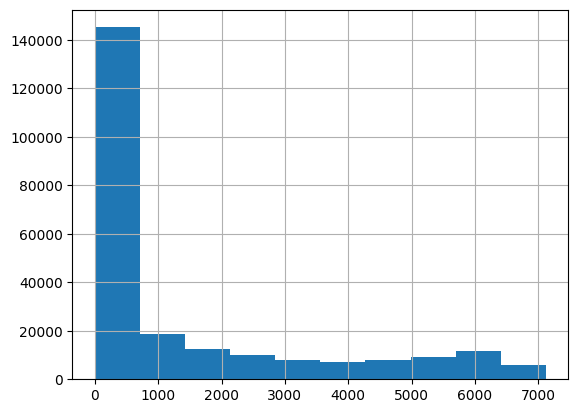

In [28]:
solardf['production'].hist()

<Axes: >

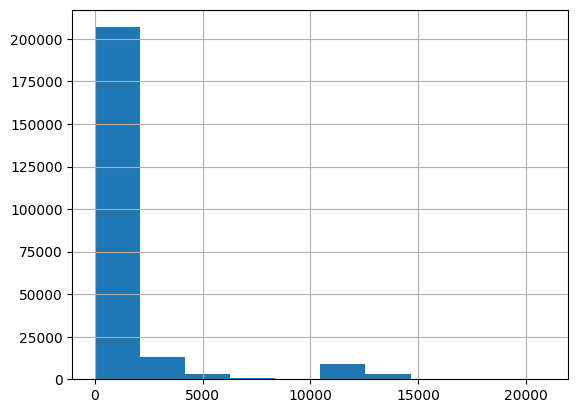

In [29]:
solardf['consumption'].hist()

# Check for gaps in the data series.

Since I log every 10 seconds, look for gaps greater than .. well, something large enough to be of interest.

In [30]:
# Calculate time interval from previous row.  
#data_intervals = solardf['datetime'].subtract(solardf['datetime'].shift(1)).dropna()
data_intervals = solardf['datetime'].diff().dropna()

# Add two columns:  interval as timedelta and as seconds
solardf['interval'] = data_intervals
solardf['intervalsec'] = data_intervals.apply(lambda x: x.seconds)
longdelayds = solardf[solardf['intervalsec'] > 300]


In [34]:
longdelayds.to_csv(f"local_{config['solardb_name']}_{config['solardb_table']}_longdelay.csv")

In [ ]:
delaymins = longdelayds['intervalsec']/60
bins = math.ceil(delaymins.max()/60) * 30
print (bins)
(longdelayds['intervalsec']/60).hist(bins=bins)

In [ ]:
longdelayds